# **1. Project introduction:**
### an introduction that discusses the data you are analyzing,and the question or questions you are investigating. 

In this project, we analyze two datasets covering all 50 U.S. states:

1. **Median Household Income (2000–2023)**  
   - Annual income data per state  
   - Used to assess purchasing power and long-term trends in earnings

2. **Median Home Values (2000–2023)**  
   - Monthly home value estimates per state, aggregated to yearly averages  
   - Reflects changes in the U.S. housing market over time

Our main research question is:  
> **Why has homeownership become increasingly unaffordable for Americans, even as incomes rise?**

To explore this, we:
- Investigate how **income and home values** have changed over time
- Calculate a **price-to-income ratio** to quantify affordability
- Analyze **regional differences** across states
- Use **machine learning** to predict future home values based on income and year
- Test the hypothesis that **rising income does not guarantee improved affordability**

# **2. Any Changes:**
### a discussion whether your scope has changed since the check-in proposal slides. 
### What did you aim to do that you will not do and what have you added to the project?

Since our initial proposal, we have made a few key adjustments:

###  **Additions:**
- We added a **machine learning component**, using linear regression to predict home prices and evaluate performance against a baseline model
- We incorporated a **hypothesis test** to examine whether income growth correlates with improved housing affordability
- We visualized affordability over time using a **heatmap**, which gave strong regional insights

###  **What We Didn't End Up Doing:**
- Initially, we considered incorporating **other economic indicators** like interest rates or inflation, but we narrowed our focus to just income and home prices to maintain clarity and depth
- We also did not build an interactive web dashboard, which was considered during brainstorming, in order to prioritize deeper analysis


# **3. Data cleaning:**
***Zillow Home Values Dataset:*** The zillow dataset contains monthly median home values from January 2000 to 2025 for 895 U.S. regions, with each row representing a region and each column (from the 6th onward) representing a specific month. The dataset has a high temporal granularity (monthly) and a wide spatial scope, covering diverse regions across the U.S. The timestamps were originally in string format and were converted to datetime objects for accurate time-based analysis. We found significant missing data. We removed the rows with more than 40% missing data. For the remaining missing values, we applied linear interpolation across time (columns), followed by forward and backward fill to handle edge cases. All numeric values were explicitly converted to float to ensure consistency and compatibility with analysis tools.

***Median Income Dataset:*** The income dataset contains annual median household income for each U.S. state from 2000 to 2023. The income values included commas (e.g., "$75,000"), which were removed, and all values were converted to numeric types. To enable merging with the home values dataset, a new column for state codes (e.g., "IL" for Illinois) was added using a standard name-to-code mapping. Both datasets were aligned on state codes for consistency in comparative analysis. No missing values were found in the income data, so no imputation was necessary.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [2]:
home_values_dataset = pd.read_csv('homevalue.csv')
income = pd.read_csv('median_income.csv')
home_values_dataset.columns.values[5:] = pd.to_datetime(home_values_dataset.columns[5:])

In [3]:
#Cleaning Data
print("\nBefore dropping missing values:")
print("New shape for home_values:", home_values_dataset.shape)

threshold = 0.4
home_values = home_values_dataset.loc[home_values_dataset.isnull().mean(axis=1) < threshold]

print("\nAfter dropping missing values:")
print("New shape for home_values:", home_values.shape)


Before dropping missing values:
New shape for home_values: (895, 306)

After dropping missing values:
New shape for home_values: (771, 306)


In [4]:
# Interpolate across columns (i.e., across time for each region)
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].interpolate(axis=1)
# Fill any remaining edge NaNs with forward/backward fill
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].bfill(axis=1).ffill(axis=1)

In [5]:
# Manually map state abbreviations to full names
abbr_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming'
}
home_values_dataset['State'] = home_values_dataset['StateName'].map(abbr_to_full)

home_long = home_values_dataset.melt(
    id_vars=['State'],
    value_vars=home_values_dataset.columns[5:-1],  # exclude trailing columns if any
    var_name='Date',
    value_name='HomeValue'
)
home_long['Year'] = pd.to_datetime(home_long['Date']).dt.year
home_yearly = home_long.groupby(['State', 'Year'])['HomeValue'].mean().reset_index()

# Clean income data
for col in income.columns[1:]:
    income[col] = income[col].str.replace(',', '').astype(float)
    income_long = income.melt(id_vars=['State'], var_name='Year', value_name='MedianIncome')
    income_long['Year'] = income_long['Year'].astype(int)

# Merge and calculate affordability
merged = pd.merge(income_long, home_yearly, on=['State', 'Year'], how='inner')
merged['PriceToIncomeRatio'] = merged['HomeValue'] / merged['MedianIncome']

# **4. Exploratory data analysis:**

### **How Affordable Is Housing in US? A State-by-Year Comparison (2000–2023)**
This heatmap visualizes the price-to-income ratio (affordability) across all states and years. California, Hawaii, and Massachusetts consistently show very high ratios, indicating low affordability. States like West Virginia, Mississippi, and Iowa tend to be more affordable. Many states show a darkening trend post-2020, reflecting worsening affordability nationwide.

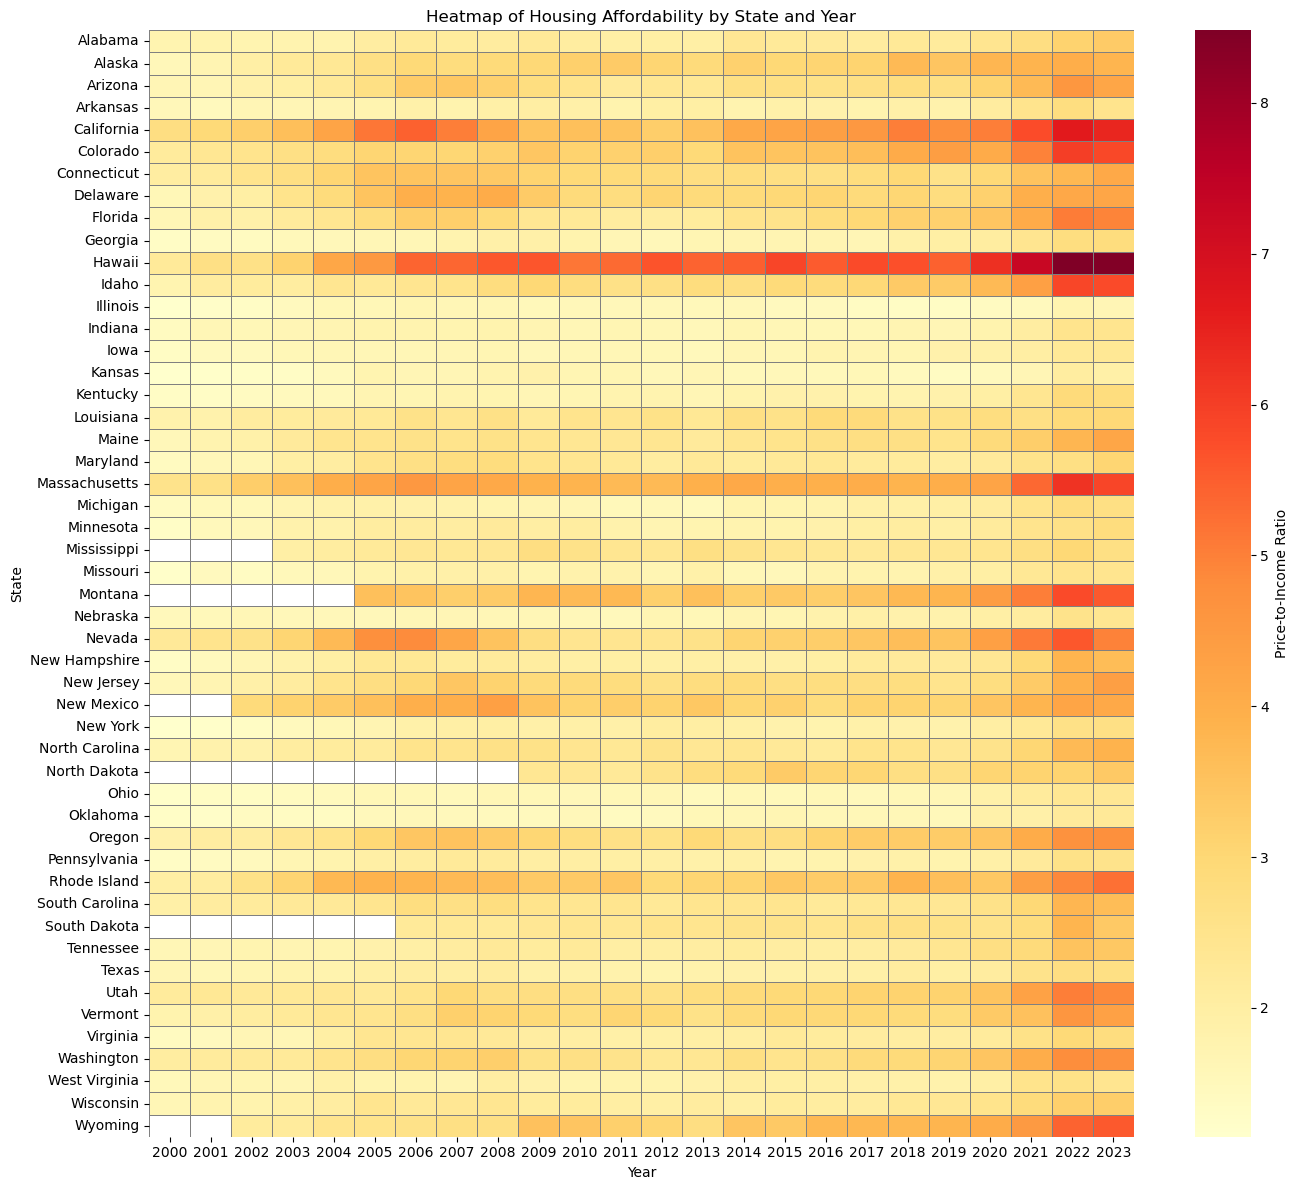

In [6]:
heatmap_data = merged.pivot(index='State', columns='Year', values='PriceToIncomeRatio')
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Price-to-Income Ratio'})
plt.title("Heatmap of Housing Affordability by State and Year")
plt.xlabel("Year")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# **5. Visualization**

### Hypothesis 1: Housing Affordability Decline ###

We hypothesized that median household income in the United States has not increased at the same rate as median home values, making it increasingly difficult for people to afford buying a home. This seemed worth exploring because of widespread media reports and social concerns about housing affordability, especially among younger generations. To test this, We created a line chart comparing national median income and median home value from 2000 to 2023. The results clearly support the hypothesis: while incomes remained relatively flat, home values rose significantly.

### Diverging Trends: U.S. National Median Income vs. Home Value (2000–2023)
This line chart compares the national median income and national median home value in the United States from 2000 to 2023. While median income has increased only modestly over the two decades, home values have risen sharply—especially after 2020. This divergence indicates a growing affordability gap, where home prices are increasing faster than people's ability to pay for them. This trend helps explain why first-time homeownership has become increasingly out of reach for many Americans.

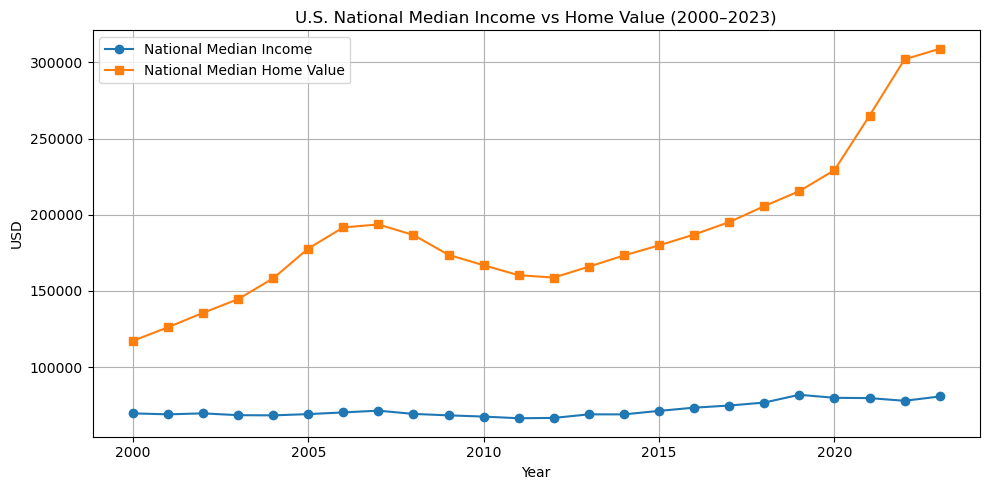

In [7]:
national_trends = merged.groupby('Year').agg({
    'MedianIncome': 'mean',
    'HomeValue': 'mean'
}).reset_index()

plt.figure(figsize=(10, 5))
plt.plot(national_trends['Year'], national_trends['MedianIncome'], label='National Median Income', marker='o')
plt.plot(national_trends['Year'], national_trends['HomeValue'], label='National Median Home Value', marker='s')
plt.title("U.S. National Median Income vs Home Value (2000–2023)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interesting Hypothesis & Visualization
### ***Hypothesis:***
### “States with faster-growing incomes have not necessarily experienced better home affordability.”

### ***Why it’s interesting:***
### It challenges the assumption that rising income should make housing more affordable.

### ***Test & Visualization:***
### Plot income growth rate vs. change in price-to-income ratio for each state.
### Use a scatter plot and label some outlier states.

# Analysis and Explanation

## ***Hypothesis***
### States with faster-growing incomes have not necessarily experienced better affordability.

## ***X-Axis: Income Growth (%)***
### Measures how much median income increased in each state between 2000 and 2023.

## ***Y-Axis: Change in Price-to-Income Ratio***
### A higher value indicates that homes became less affordable, even if incomes grew.

## **Key Observations**

### *1. No Strong Negative Correlation*
### The regression line is flat or slightly positive, suggesting that higher income growth did not lead to improved affordability.
### In fact, some states with strong income growth still saw affordability decline (e.g., Massachusetts, Washington, Utah).

### *2. Extreme Cases*
### Hawaii: Very large increase in price-to-income ratio, even though income growth was modest → affordability worsened significantly.
### Massachusetts: High income growth and one of the worst changes in affordability → prices outpaced earnings drastically.

### *3. Affordability Improved or Stayed Stable in Some States*
### A few states like Indiana, Pennsylvania, and Ohio have a relatively low change in price-to-income ratio, suggesting housing affordability remained stable.
### These states also had moderate income growth, showing a better balance between wages and housing costs.
 
## ***Conclusion***
### our hypothesis is supported by this plot:
### Income growth alone does not guarantee improved affordability.
### Housing affordability is influenced by factors beyond income, such as:
#### - Real estate demand
#### - Supply constraints
#### - Population growth and urban migration
#### - Interest rates and investment trends

### Here are the **overall observations** from our cleaned and merged dataset, based on the exploratory data analysis (EDA) and visualizations:

---

## **1. Home Prices Are Growing Much Faster Than Incomes**
- The **national trend plot** shows that from 2000 to 2023, **median home values have increased significantly**, especially after 2020.
- In contrast, **median income** has grown at a much slower and steadier pace.
- This widening gap suggests that **housing has become less affordable** for the average American over time.

---

## **2. Housing Affordability Is Declining in Most States**
- The **price-to-income ratio** (a key measure of affordability) has **increased across nearly all states**, especially in recent years.
- The **heatmap** reveals that states like **California, Hawaii, and Massachusetts** consistently have high ratios, indicating poor affordability.
- In contrast, states like **West Virginia, Mississippi, and Iowa** have maintained relatively low ratios, indicating better affordability.

---

## **3. Income Growth Doesn’t Always Improve Affordability**
- The **hypothesis test** showed **no strong negative correlation** between income growth and improved affordability.
- Some states with **high income growth** (like Massachusetts or Washington) still experienced **large declines in affordability**.
- Others with **moderate income growth** (like Indiana or Pennsylvania) maintained better housing affordability.

---

## **4. Regional Inequality Is Growing**
- Affordability varies **significantly by state and region**. Coastal and urban areas have seen the sharpest price increases relative to income.
- This suggests that while some regions remain accessible to first-time buyers, others have become increasingly out of reach — even for higher-income households.

---

### **Conclusion**
Our analysis confirms that **rising income is not enough to offset housing market pressures**. The imbalance between income and housing costs has grown worse in many areas, and policy or market interventions may be needed to restore affordability — especially in high-demand regions.



# **6. Machine Learning analysis**
The goal of this ML analysis is to identify patterns in affordability accross US states that are not immediately visible in raw data, and to segment states into categories with respect to their affordability.

In [13]:
import all_functions
state_yearly_df = all_functions.homevalues_dataset(home_values)

In [14]:
income = pd.read_csv('median_income.csv')
income = all_functions.income_dataset_ML(income)

homevalues_dataset() and income_dataset_ML() function prepares the homevalues and income data to feed into the clustering algorithm. Homevalues of all the regions of each state are averaged so that we can get one homevalue per state for each year 2000 to 2023. And in the income dataset, a separate column has been introduced for the State Codes.

### **K-Means Clustering**
Since there were no labeled outcomes or predefined affordability categories in the data, we chose unsupervised learning, specifically K-Means clustering, to let the data reveal natural groupings. K-Means is effective for partitioning data based on feature similarity and is well-suited to exploratory segmentation problems like this. To capture both current and long-term affordability trends, we used the following four features per state:
- Median Home Value in 2023
- Home Value Growth Rate (2000–2023)
- Median Income in 2023
- Income Growth Rate (2000–2023)

clustering() function is doing all the above mentioned processing and returning a dataframe for clustering. All features of the dataframe are normalized using standard scaling to ensure equal weighting in the clustering algorithm.

In [15]:
clustering_df = all_functions.clustering(state_yearly_df, income)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

### BaseLine: Choosing the value of K
To determine the optimal number of clusters (K), we used the Elbow Method and Silhouette Score. The elbow plot showed diminishing returns after K=3, and although the silhouette score peaked at K=2, the interpretability of K=3 (high, moderate, and low affordability) aligned better with the real-world context of the problem. Therefore, K=3 was selected.

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory le

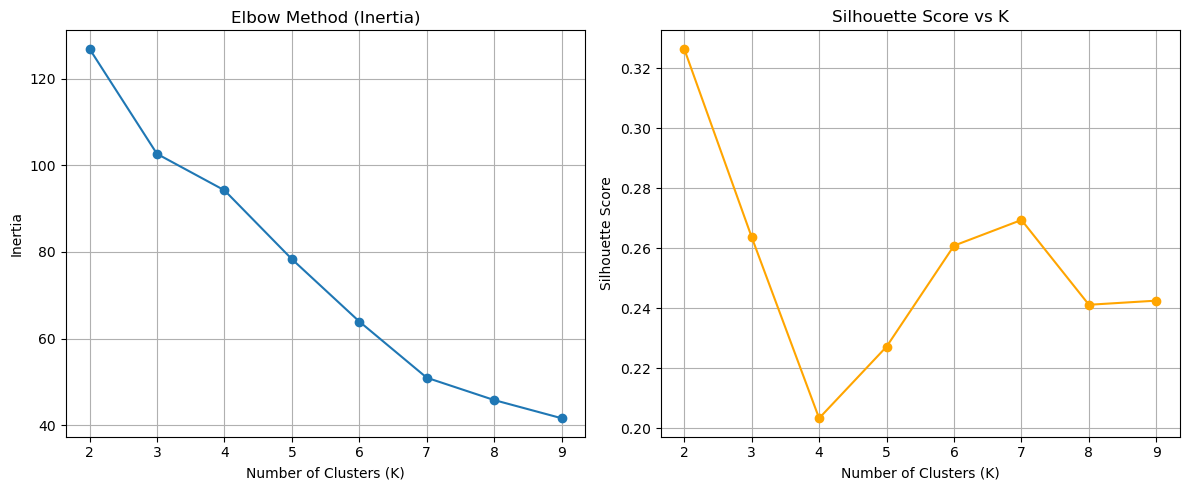

In [11]:
# Range of K values to try
K_range = range(2, 10)

inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)  # scaled_data = standardized feature matrix from earlier
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plotting
plt.figure(figsize=(12, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['Cluster'] = kmeans.fit_predict(scaled_data)
# map cluster labels to affordability level
cluster_map = {
    0: 'Moderate Affordability',
    1: 'High Affordability',
    2: 'Low Affordability'
}
clustering_df['Affordability'] = clustering_df['Cluster'].map(cluster_map)
clustering_df.head()

E:\Anaconda24\envs\cs418env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,HomeValue_2023,HomeValue_Growth,Income_2023,Income_Growth,Cluster,Affordability
StateName,,,,,,
NY,217244.254634,177.663556,81600.0,20.088300,1,High Affordability
CA,593357.691233,203.980242,89870.0,15.114641,2,Low Affordability
IL,148540.889778,43.330029,87820.0,14.319188,0,Moderate Affordability
TX,216411.865369,87.296005,79060.0,22.783041,1,High Affordability
VA,270847.217093,122.690736,96490.0,22.682772,1,High Affordability


### Results & Interpretation
The clustering grouped states into three affordability tiers. States like Texas, Iowa, and Mississippi were clustered as high affordability, while California, Hawaii were identified as low affordability. Some states formed a moderate affordability group. These clusters are visualized on a U.S. map using color-coded choropleth shading, clearly showing regional patterns in affordability.

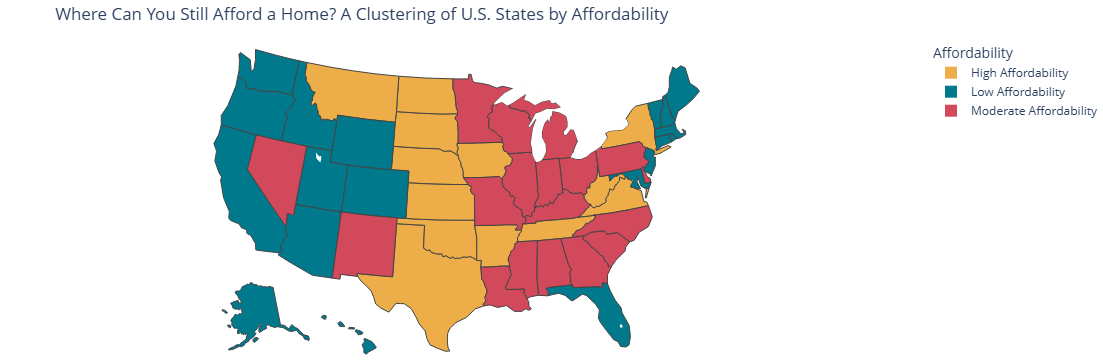

In [22]:
map_df = clustering_df.reset_index()[['Affordability']]
map_df['StateCode'] = clustering_df.index

fig = px.choropleth(
    map_df,
    locations='StateCode',
    locationmode='USA-states',
    color='Affordability',
    color_discrete_map={
        'High Affordability': '#edae49',
        'Moderate Affordability': '#d1495b',
        'Low Affordability': '#00798c'
    },
    hover_name='StateCode',
    scope='usa',
    title='Where Can You Still Afford a Home? A Clustering of U.S. States by Affordability'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

## **Where Can You Still Afford a Home? A Clustering of U.S. States by Affordability**
This map shows the results of a K-Means clustering analysis that grouped U.S. states into three categories based on housing affordability: high, moderate, or low affordability based on the relationship between rising home prices and income levels. High Affordable states tend to have relatively low home values and/or healthy income growth, making it easier for residents to afford homes. Many of these are in the central and mountain regions, such as Montana, Texas, and Maine. 
Moderate Affordabile states fall somewhere in the middle — either with moderate home values and income, or a balance of high values with strong income growth. This group includes a mix of Midwestern and Southern states like Tennessee, Michigan, and Pennsylvania.
Low Affordabile states are where home prices have significantly outpaced income growth, making housing much harder to afford. These include coastal states like California, Florida, which are known for high cost-of-living pressures.

The map visually confirms a growing affordability divide in the U.S., with coastal and southern states generally showing lower affordability, while some interior and less densely populated states remain more accessible for homebuyers. The clustering offers a data-driven lens to understand how economic and housing market trends are shaping access to homeownership nationwide.

# ***7. Reflection: a discussion of the following:***

### o What is hardest part of the project that you’ve encountered so far?
- The most challenging part of the project was cleaning and aligning the two datasets, which had different formats:

- The home value dataset was monthly and used state abbreviations

- The income dataset was yearly and used full state names We had to reshape the data, create a state mapping, aggregate monthly data into yearly averages, and ensure accurate merging. Missing values and inconsistent time coverage added to the complexity.

### o What are your initial insights?
- Home prices are rising faster than income in almost every state, especially since 2020

- States like California, Hawaii, and Massachusetts are significantly less affordable than the national average

- Income growth does not reliably lead to improved affordability, confirming our initial hypothesis

- Regional variation is stark — some low-income states are actually more affordable than high-income ones

### o Are there any concrete results you can show at this point? If not, why not?
Yes, we have several:

- A national trend line showing the gap between income and home prices widening

- A heatmap of affordability by state and year, showing where affordability has worsened

- A machine learning model that predicts home values with lower error than a naive baseline

- A hypothesis test plot confirming that higher income growth doesn't correlate with improved affordability

### o Going forward, what are the current biggest problems you’re facing?
- Our current model is limited in scope — it only uses income and year. While it performs better than a baseline, its predictive power could be stronger with more variables (e.g., mortgage rates, population growth, construction rates)

- Visualizations are effective but need polishing for presentation

### o Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?
Yes, we are on track:

- We've completed the major parts of cleaning, merging, visualizing, and modeling

- What remains is improving the visual design, summarizing findings, and wrapping the project into a clean presentation or report

### o Given your initial exploration of the data, is it worth proceeding with yourproject, why? 

### If not, how are you going to change your project and why do you think it’s better than your current results?

Absolutely. The trends are real, the results are meaningful, and the topic is highly relevant. The insights can help homebuyers, policymakers, and researchers understand the housing affordability crisis from a data-driven perspective.



# ***8. Next steps:***
### What you plan to accomplish in the next month and how you plan to evaluate whether your project achieved the goals you set for it.
### In the Next Month, We Plan To:
- Finalize visualizations for presentation (clean formatting, optional interactive versions)

- Write up results and conclusions, including polished versions of our graphs

- Optional: Test a more advanced machine learning model like Random Forest or XGBoost to improve predictions

- Prepare final presentation or paper, clearly communicating our process, results, and conclusions

### How We'll Evaluate Our Project's Success
- If we can clearly show trends in affordability across time and states

- If our ML model performs better than a naive approach

- If we can communicate insights clearly through visuals and explanations

- If our findings support our hypothesis with real data and analysis

Link to the functions file: https://github.com/uic-cs418/group-project-stat-squad/blob/main/all_functions.py